In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("/content/drive/MyDrive/UCLA MSBA/weather_data/data.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10074 entries, 0 to 10073
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    10074 non-null  object 
 1   TMAX    10074 non-null  int64  
 2   TMIN    10074 non-null  int64  
 3   PRCP    10074 non-null  float64
 4   AWND    10073 non-null  float64
 5   WDF2    10072 non-null  float64
 6   WSF2    10072 non-null  float64
 7   year    10074 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 629.8+ KB


In [ ]:
#shifting target variable up 1 day
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE')
df['y'] = df['TMAX'].shift(-1)
df = df.dropna(subset=['y'])


In [ ]:
#adding a rolling average
windows = [3, 7, 14]

for w in windows:
    df[f'TMAX_roll_mean_{w}'] = df['TMAX'].rolling(w).mean()
    df[f'TMAX_roll_std_{w}']  = df['TMAX'].rolling(w).std()


In [ ]:
#seasonality
df['month'] = df['DATE'].dt.month
df['dayofyear'] = df['DATE'].dt.dayofyear

# cyclic encoding (recommended)
df['sin_doy'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
df['cos_doy'] = np.cos(2 * np.pi * df['dayofyear'] / 365)


In [ ]:
#lags
lags = [1, 2, 3, 7, 14]
for l in lags:
    df[f'TMAX_lag_{l}'] = df['TMAX'].shift(l)
    df[f'TMIN_lag_{l}'] = df['TMIN'].shift(l)


In [ ]:
#drop nulls (almost none)
df = df.dropna()
X = df.drop(columns=['DATE', 'y'])
y = df['y']

split_date = '2019-01-01'

X_train = X[df['DATE'] < split_date]
y_train = y[df['DATE'] < split_date]

X_test  = X[df['DATE'] >= split_date]
y_test  = y[df['DATE'] >= split_date]


In [ ]:
#first basic model: best prediction is yesterdays max
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred_lag = X_test['TMAX_lag_1']
rmse_lag = np.sqrt(mean_squared_error(y_test, y_pred_lag))
print(rmse_lag)

6.231884654317082


In [ ]:
#second benchmark: ridge
from sklearn.linear_model import Ridge

model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train, y_train)
y_pred = model_ridge.predict(X_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred))

print(rmse_ridge)

4.125060166237235


In [ ]:
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV


# 1) Time-series CV setup
tscv = TimeSeriesSplit(n_splits=5)


# 2) Model + hyperparameter search
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    tree_method="hist"  # fast + good default
)

param_distributions = {
    "n_estimators": [400, 700, 1000, 1400],
    "learning_rate": [0.01, 0.03, 0.05, 0.08, 0.1],
    "max_depth": [2, 3, 4, 5, 6, 8],
    "min_child_weight": [1, 3, 5, 10],
    "subsample": [0.6, 0.75, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.75, 0.9, 1.0],
    "gamma": [0, 0.5, 1, 2, 5],
    "reg_alpha": [0, 1e-3, 1e-2, 1e-1, 1],
    "reg_lambda": [0.5, 1, 2, 5, 10],
}

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=40,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)
best_model = search.best_estimator_

print("Best CV RMSE:", -search.best_score_)
print("Best params:", search.best_params_)

y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"TEST  RMSE: {rmse:,.3f}")
print(f"TEST   MAE: {mae:,.3f}")
print(f"TEST    R2: {r2:,.3f}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best CV RMSE: 4.31058757957152
Best params: {'subsample': 0.6, 'reg_lambda': 10, 'reg_alpha': 0.01, 'n_estimators': 1400, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 5, 'colsample_bytree': 1.0}
TEST  RMSE: 4.046
TEST   MAE: 2.888
TEST    R2: 0.686


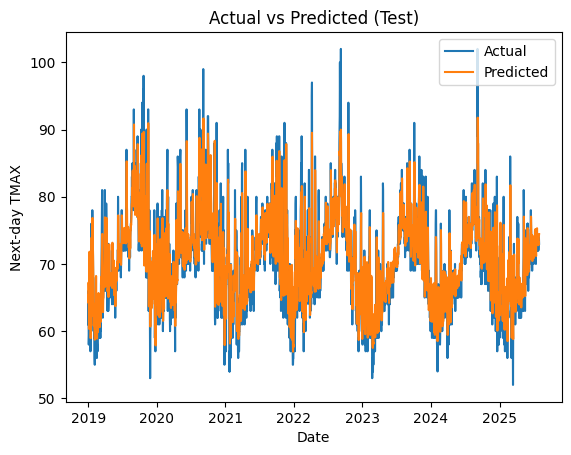

In [ ]:
dates_test = pd.to_datetime(df.loc[X_test.index, "DATE"])

plt.figure()
plt.plot(dates_test, y_test.values, label="Actual")
plt.plot(dates_test, y_pred, label="Predicted")
plt.title("Actual vs Predicted (Test)")
plt.xlabel("Date")
plt.ylabel("Next-day TMAX")
plt.legend()
plt.show()



Mean absolute error by month:
month
1     3.845635
2     3.208922
3     3.039726
4     2.991811
5     1.994717
6     1.727361
7     1.714072
8     2.240339
9     3.207989
10    3.484575
11    4.039303
12    3.477163
Name: abs_err, dtype: float64

Mean signed error (bias) by month (positive=underpredict):
month
1    -0.429328
2    -0.326095
3    -0.222819
4    -0.241930
5    -0.661753
6    -0.377304
7    -0.219314
8     0.103679
9     0.223900
10    0.136762
11    0.026596
12   -0.366886
Name: err, dtype: float64


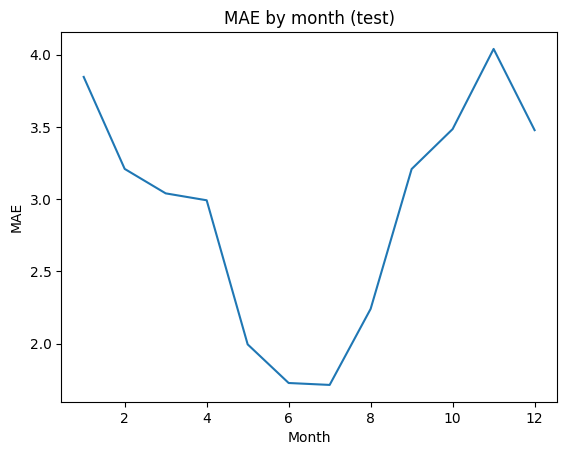

In [ ]:
tmp = df.loc[X_test.index, ["DATE"]].copy()
tmp["DATE"] = pd.to_datetime(tmp["DATE"])
tmp["month"] = tmp["DATE"].dt.month
tmp["y_true"] = y_test.values
tmp["y_pred"] = y_pred
tmp["abs_err"] = np.abs(tmp["y_true"] - tmp["y_pred"])
tmp["err"] = tmp["y_true"] - tmp["y_pred"]

monthly = tmp.groupby("month")[["abs_err", "err"]].mean().sort_index()
print("\nMean absolute error by month:")
print(monthly["abs_err"])
print("\nMean signed error (bias) by month (positive=underpredict):")
print(monthly["err"])

plt.figure()
plt.plot(monthly.index, monthly["abs_err"])
plt.title("MAE by month (test)")
plt.xlabel("Month")
plt.ylabel("MAE")
plt.show()
